# *Decision Tree* classification of Countries of the World data 

Prediction of the birth rate class of a given country (low, medium or high) based on a set of input features using **Decision Tree Learning**.

- Data is provided for **224** countries
- Up to **18** input features available per country 

**Tasks**:
- Selecting a subset of suitable input features
- Preparing the data for Scikit Learn  
- Creating a training and testing sample 
- Running the decision tree classification process and evaluate predictive power  
- Investigating prediction accuracy changes with hyper-parameter tuning and ensemble methods  

In [1]:
# import required package
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import datasets, tree, metrics, model_selection, ensemble
from sklearn.externals.six import StringIO 
from IPython.display import Image
import pydotplus
import itertools
import seaborn as sns
from scipy import stats
import dt_utils
from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline 

#### 1. Data Extraction
- The features can be any of the following: 
  - Population, Area, Density, Coastline, Migration, InfantMortality, GDP, Literacy, Phones, Arable, Crops, OtherLand, Climate, Deathrate, Agriculture, Industry, Service
  - More information on the dataset is available [here](https://www.kaggle.com/fernandol/countries-of-the-world)
- Only 4 features are chosen as input into the Decision Tree. 

In [2]:
# Load country dataset 
bclass = ['low', 'medium', 'high'] # birth rate class (provided)
features_all = ['Population', 'Area', 'Density', 'Coastline', 'Migration', 'InfantMortality', 'GDP', 'Literacy', 'Phones', 'Arable', 'Crops', 'OtherLand', 'Climate', 'Deathrate', 'Agriculture', 'Industry', 'Service'] # fdefine features here 
data_all = dt_utils.gendata(features_all)

In [3]:
#Widen the output display to see more columns
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

# Display sample entry
df = pd.read_csv('countries.csv', decimal=",")
df.head(10)

,Country,Region,Population,Area (sq. mi.),Pop. Density (per sq. mi.),Coastline (coast/area ratio),Net migration,Infant mortality (per 1000 births),GDP ($ per capita),Literacy (%),Phones (per 1000),Arable (%),Crops (%),Other (%),Climate,Birthrate,Deathrate,Agriculture,Industry,Service
0,Afghanistan,ASIA (EX. NEAR EAST),31056997,647500,48.0,0.00,23.06,163.07,700.0,36.0,3.2,12.13,0.22,87.65,1.0,46.60,20.34,0.380,0.240,0.380
1,Albania,EASTERN EUROPE,3581655,28748,124.6,1.26,-4.93,21.52,4500.0,86.5,71.2,21.09,4.42,74.49,3.0,15.11,5.22,0.232,0.188,0.579
2,Algeria,NORTHERN AFRICA,32930091,2381740,13.8,0.04,-0.39,31.00,6000.0,70.0,78.1,3.22,0.25,96.53,1.0,17.14,4.61,0.101,0.600,0.298
3,American Samoa,OCEANIA,57794,199,290.4,58.29,-20.71,9.27,8000.0,97.0,259.5,10.00,15.00,75.00,2.0,22.46,3.27,NaN,NaN,NaN
4,Andorra,WESTERN EUROPE,71201,468,152.1,0.00,6.60,4.05,19000.0,100.0,497.2,2.22,0.00,97.78,3.0,8.71,6.25,NaN,NaN,NaN
5,Angola,SUB-SAHARAN AFRICA,12127071,1246700,9.7,0.13,0.00,191.19,1900.0,42.0,7.8,2.41,0.24,97.35,NaN,45.11,24.20,0.096,0.658,0.246
6,Anguilla,LATIN AMER. & CARIB,13477,102,132.1,59.80,10.76,21.03,8600.0,95.0,460.0,0.00,0.00,100.00,2.0,14.17,5.34,0.040,0.180,0.780
7,Antigua & Barbuda,LATIN AMER. & CARIB,69108,443,156.0,34.54,-6.15,19.46,11000.0,89.0,549.9,18.18,4.55,77.27,2.0,16.93,5.37,0.038,0.220,0.743
8,Argentina,LATIN AMER. & CARIB,39921833,2766890,14.4,0.18,0.61,15.18,11200.0,97.1,220.4,12.31,0.48,87.21,3.0,16.73,7.55,0.095,0.358,0.547
9,Armenia,C.W. OF IND. STATES,2976372,29800,99.9,0.00,-6.47,23.28,3500.0,98.6,195.7,17.55,2.30,80.15,4.0,12.07,8.23,0.239,0.343,0.418


In [4]:
# Choose only 4 features
feature_idx = [5, 6, 7, 11]
data, target = data_all[:, feature_idx], data_all[:, [-1]].ravel()

In [5]:
# Show feature names
features = []
for i in feature_idx:
    features.append(features_all[i])
features

['InfantMortality', 'GDP', 'Literacy', 'OtherLand']

In [6]:
# Show dataset dimensions
data.shape, target.shape, np.unique(target)

((179, 4), (179,), array(['high', 'low', 'medium'], dtype=object))

#### 2. The feature distribution of the selected observations

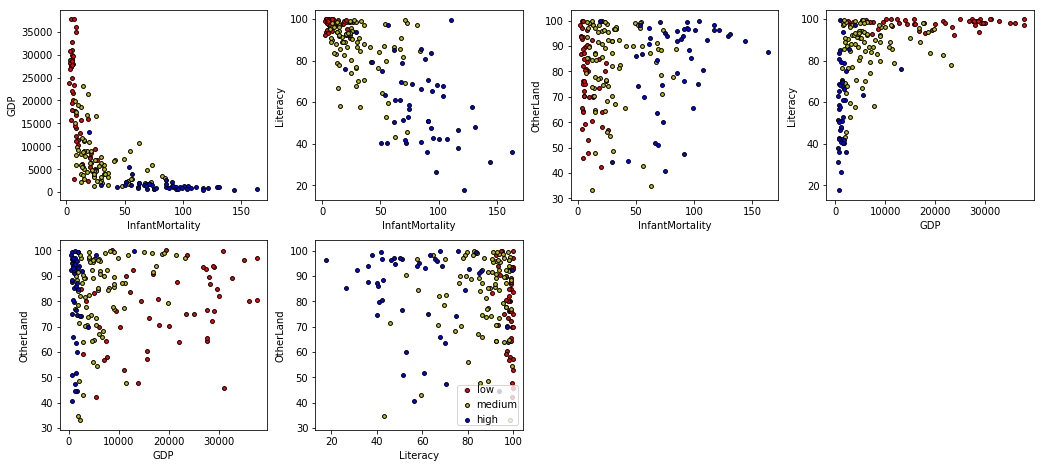

In [7]:
# generate 2D plots 
dt_utils.cp4plot(data, target, features, bclass)
plt.show()

#### 3. Constructing and training the Decision Tree based on your training data with the following requirements
- 70% of the observations are reserved for training
- Tree depth is limited to 5 

In [8]:
# train test split
d = model_selection.train_test_split(
    data, target, test_size=0.3, random_state=0)

# get training and test data and targets
train_data, test_data, train_target, test_target = d

print(train_data.shape, train_target.shape, test_data.shape, test_target.shape)

(125, 4) (125,) (54, 4) (54,)


In [9]:
%%time
# define classifier 
clf = tree.DecisionTreeClassifier(max_depth=5)
fit = clf.fit(train_data, train_target)

# define expected and predicted 
expected, predicted = dt_utils.runML(clf, d)

Wall time: 2 ms


#### 4. Displaying the generated decision tree logic
- Just use the utility method available in `dt_utils` to generate the tree

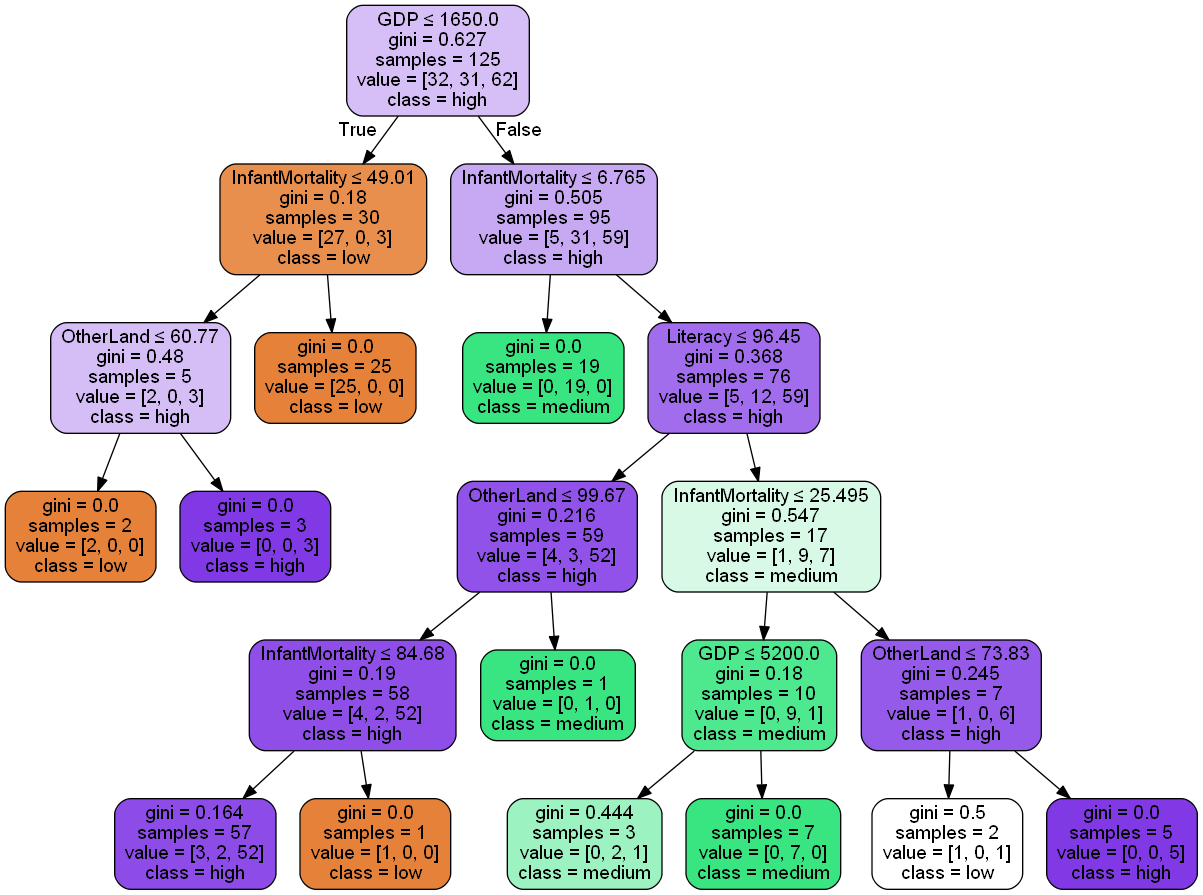

In [10]:
# plot tree
graph = dt_utils.plotDT(fit, features, bclass)
Image(graph.create_png())

#### 5. Displaying the classification report and confusion matrix for the predictions using the test sample

In [11]:
# display classification report
report = metrics.classification_report(expected, predicted, target_names=bclass)
print(report)

# accuracy score 
acc = metrics.accuracy_score(expected, predicted)
print('Accuracy : {}'.format(acc))

             precision    recall  f1-score   support

        low       0.92      0.73      0.81        15
     medium       0.75      0.90      0.82        20
       high       0.78      0.74      0.76        19

avg / total       0.81      0.80      0.80        54

Accuracy : 0.7962962962962963


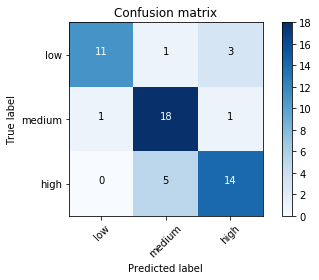

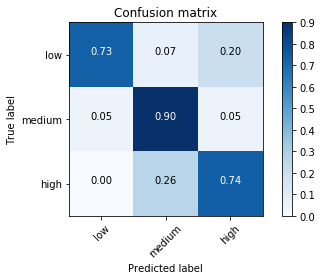

In [12]:
# display confusion matrix
cm = metrics.confusion_matrix(expected, predicted)

# plot confusion matrix 
dt_utils.plot_cm(cm, bclass)
plt.show()

# normalized confusion matrix
dt_utils.plot_cm(cm, bclass, normalize=True)
plt.show()

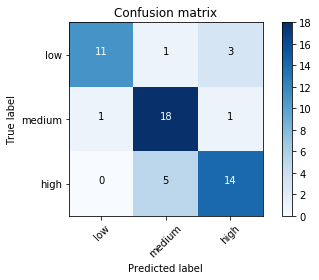

In [13]:
# display confusion matrix
cm = metrics.confusion_matrix(expected, predicted)
# plot confusion matrix 
dt_utils.plot_cm(cm, bclass)
plt.show()

The high birth rate class have (column) false positives and (row) false negatives.

#### 6. Running the cross-validation to determine the average accuracy
- Splitting the data into **5** folds and using the whole dataset as part of the cross-validation

In [14]:
scores = model_selection.cross_val_score(clf, data, target, cv=5)
print(scores)
print("CV Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

[0.78947368 0.75       0.85714286 0.74285714 0.85714286]
CV Accuracy: 0.80 (+/- 0.10)


#### 7. Performing a grid-search on **two** suitable hyper-parameters to look for higher accuracy

In [15]:
# estimate hyperparameter
params = {'max_leaf_nodes' : [3, 4, 5, 6, 7, 8, 9, 15], 
          'max_depth' : [2, 3, 4, 5, 6, 7, 8, 9]
         }
score = 'accuracy'

# tuning hyperparameter
clf = model_selection.GridSearchCV(tree.DecisionTreeClassifier(), params, cv=5, scoring='%s' % score)
clf.fit(train_data, train_target)

# define expected and predicted 
expected1 = test_target
predicted1 = clf.predict(test_data)
print(clf.best_params_)

# Calculate the means and stds test score
means = clf.cv_results_['mean_test_score']
stds = clf.cv_results_['std_test_score']

# for mean, std, param in zip(means, stds, clf.cv_results_['params']):
#         print("%0.3f (+/-%0.03f) for %r"
#               % (mean, std * 2, param))

{'max_depth': 3, 'max_leaf_nodes': 5}


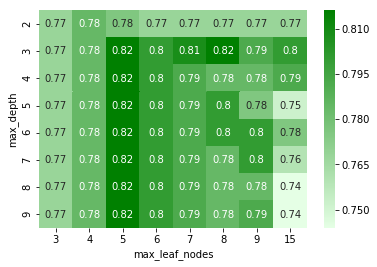

In [16]:
# display heatmap
labels = [k for k,v in params.items()]
classes = [v for k,v in params.items()]
dt_utils.heatmap(means.reshape(8, 8), classes=classes, labels=labels, palette="Green")
plt.show()

In [17]:
# display classification report 
report = metrics.classification_report(expected1, predicted1, target_names=bclass)
print(report)
# accuracy score 
acc1 = metrics.accuracy_score(expected1, predicted1)
print('Accuracy : {}'.format(acc1))

             precision    recall  f1-score   support

        low       1.00      0.60      0.75        15
     medium       0.82      0.90      0.86        20
       high       0.65      0.79      0.71        19

avg / total       0.81      0.78      0.78        54

Accuracy : 0.7777777777777778


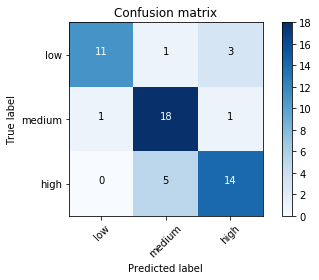

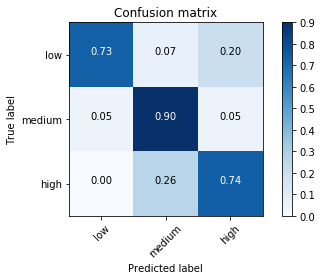

In [18]:
# display confusion matrix
cm = metrics.confusion_matrix(expected, predicted)
# plot confusion matrix 
dt_utils.plot_cm(cm, bclass)
plt.show()

# normalized confusion matrix
dt_utils.plot_cm(cm, bclass, normalize=True)
plt.show()

The high birth rate class have (column) false positives and (row) false negatives.

In [19]:
scores = model_selection.cross_val_score(clf, data, target, cv=5)
print(scores)
print("CV Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

[0.76315789 0.80555556 0.88571429 0.74285714 0.85714286]
CV Accuracy: 0.81 (+/- 0.11)


#### 8. Repeating the decision tree analysis to try and improve upon the classification performance

- As shown below, the classification is improved when using an ensemble method.

Figure below shows the variation in accuracy as the testing and training sample proportion vary.

parameters
None
Split sample:
[0.01 0.02 0.03 0.04 0.05 0.06 0.07 0.08 0.09 0.1  0.2  0.3  0.4  0.5
 0.6  0.7  0.8  0.9  0.91 0.92 0.93 0.94 0.95 0.96 0.97 0.98 0.99]
Running with test size of: 0.01
Running with test size of: 0.02
Running with test size of: 0.03
Running with test size of: 0.04
Running with test size of: 0.05
Running with test size of: 0.06
Running with test size of: 0.07
Running with test size of: 0.08
Running with test size of: 0.09
Running with test size of: 0.10
Running with test size of: 0.20
Running with test size of: 0.30
Running with test size of: 0.40
Running with test size of: 0.50
Running with test size of: 0.60
Running with test size of: 0.70
Running with test size of: 0.80
Running with test size of: 0.90
Running with test size of: 0.91
Running with test size of: 0.92
Running with test size of: 0.93
Running with test size of: 0.94
Running with test size of: 0.95
Running with test size of: 0.96
Running with test size of: 0.97
Running with test size of: 0.98
R

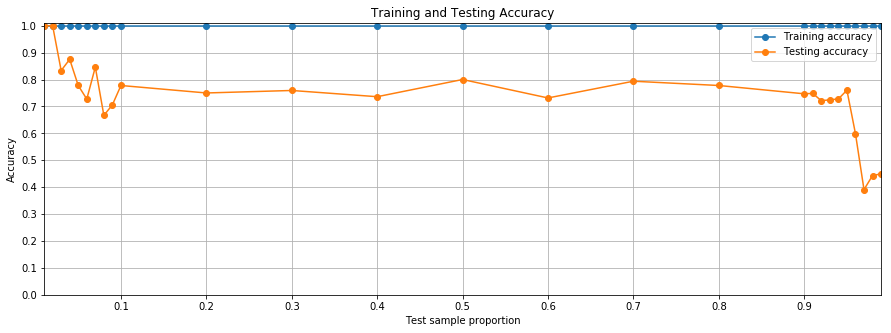

In [20]:
dt_utils.compare_traintest(data, target)

In [21]:
# define classifier 
clf = ensemble.RandomForestClassifier(n_estimators=10, max_features=4)

# train test split
d = model_selection.train_test_split(data, target, test_size=0.5, random_state=0)

# define expected and predicted 
e, p = dt_utils.runML(clf, d)

# display classification report
report = metrics.classification_report(e, p)
print(report)

# accuracy score 
acc = metrics.accuracy_score(e, p)
print('Accuracy : {}'.format(acc))

             precision    recall  f1-score   support

       high       0.88      0.88      0.88        25
        low       0.85      0.85      0.85        27
     medium       0.82      0.82      0.82        38

avg / total       0.84      0.84      0.84        90

Accuracy : 0.8444444444444444


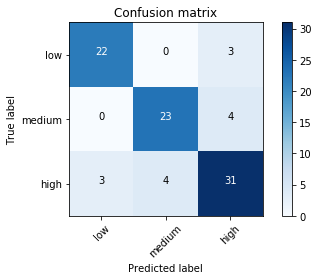

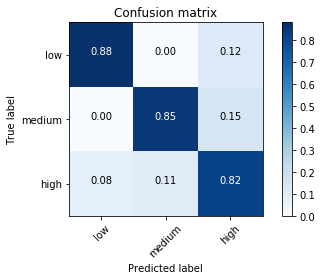

In [22]:
# display confusion matrix
cm = metrics.confusion_matrix(e, p)

# plot confusion matrix 
dt_utils.plot_cm(cm, bclass)
plt.show()

# normalized confusion matrix
dt_utils.plot_cm(cm, bclass, normalize=True)
plt.show()

The high birth rate class have (column) false positives and (row) false negatives.

{'max_features': 2, 'n_estimators': 100}
15
Wall time: 12.4 s


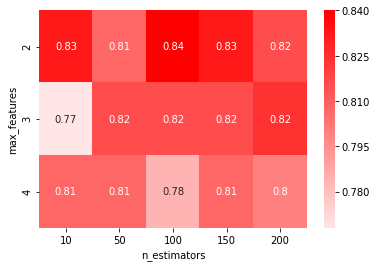

In [23]:
%%time
# estimate hyperparameter (n_estimator - no of tree in forest)
params2 = {'n_estimators' : [10, 50, 100, 150, 200], 
          'max_features' : [2, 3, 4]
         }
score = 'accuracy'

# tuning hyperparameter
clf = model_selection.GridSearchCV(ensemble.RandomForestClassifier(), params2, cv=5, scoring='%s' % score)
clf.fit(train_data, train_target)
e1 = test_target
p1 = clf.predict(test_data)
print(clf.best_params_)

# Calculate the mean test score
means = clf.cv_results_['mean_test_score']
print(len(means))

# display heatmap
labels = [k for k,v in params2.items()]
classes = [v for k,v in params2.items()]
dt_utils.heatmap(means.reshape(3, 5), classes=classes, labels=labels, palette="Red")

In [24]:
# display classification report 
report = metrics.classification_report(e1, p1, target_names=bclass)
print(report)
# accuracy score 
acc = metrics.accuracy_score(e1, p1)
print('Accuracy : {}'.format(acc))

scores = model_selection.cross_val_score(clf, data, target, cv=5)
print('--------------------------------------------------')
print(scores)
print("CV Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

             precision    recall  f1-score   support

        low       1.00      0.87      0.93        15
     medium       0.89      0.85      0.87        20
       high       0.77      0.89      0.83        19

avg / total       0.88      0.87      0.87        54

Accuracy : 0.8703703703703703
--------------------------------------------------
[0.84210526 0.77777778 0.88571429 0.77142857 0.88571429]
CV Accuracy: 0.83 (+/- 0.10)


- Below are the case for when two extra features are used as input features and also using ensemble method. It is found out the best number of features used, given those features, is 4 instead of 5 and 6.
- Having more than four input could improve the classification but it depends on the combination of input features taken.

In [25]:
# create feature data for 6 available features.
feature_idx = [5, 6, 7, 9, 10, 11]
data_new = data_all[:, feature_idx]

# Show feature names
features = []
for i in feature_idx:
    features.append(features_all[i])
features

['InfantMortality', 'GDP', 'Literacy', 'Arable', 'Crops', 'OtherLand']

Figure below shows the variation in accuracy as the testing and training sample proportion vary.

parameters
None
Split sample:
[0.01 0.02 0.03 0.04 0.05 0.06 0.07 0.08 0.09 0.1  0.2  0.3  0.4  0.5
 0.6  0.7  0.8  0.9  0.91 0.92 0.93 0.94 0.95 0.96 0.97 0.98 0.99]
Running with test size of: 0.01
Running with test size of: 0.02
Running with test size of: 0.03
Running with test size of: 0.04
Running with test size of: 0.05
Running with test size of: 0.06
Running with test size of: 0.07
Running with test size of: 0.08
Running with test size of: 0.09
Running with test size of: 0.10
Running with test size of: 0.20
Running with test size of: 0.30
Running with test size of: 0.40
Running with test size of: 0.50
Running with test size of: 0.60
Running with test size of: 0.70
Running with test size of: 0.80
Running with test size of: 0.90
Running with test size of: 0.91
Running with test size of: 0.92
Running with test size of: 0.93
Running with test size of: 0.94
Running with test size of: 0.95
Running with test size of: 0.96
Running with test size of: 0.97
Running with test size of: 0.98
R

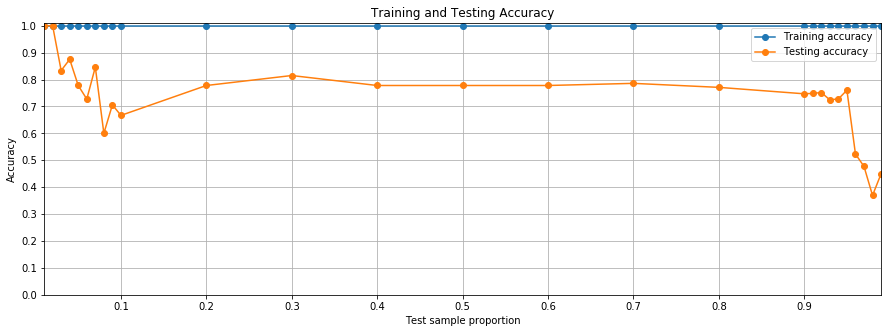

In [26]:
dt_utils.compare_traintest(data_new, target)

In [27]:
# define classifier
clf = ensemble.RandomForestClassifier(n_estimators=10, max_features=6)

# train test split
dX = model_selection.train_test_split(data_new, target, test_size=0.3, random_state=0)
train_dataX, test_dataX, train_targetX, test_targetX = dX[0], dX[1], dX[2], dX[3]

# define expected and predicted 
eX, pX = dt_utils.runML(clf, dX)

# display classification report
reportX = metrics.classification_report(eX, pX)
print(reportX)

# accuracy score (harder to get >90%)
accX = metrics.accuracy_score(eX, pX)
print('Accuracy : {}'.format(accX))

             precision    recall  f1-score   support

       high       0.93      0.87      0.90        15
        low       0.86      0.90      0.88        20
     medium       0.79      0.79      0.79        19

avg / total       0.85      0.85      0.85        54

Accuracy : 0.8518518518518519


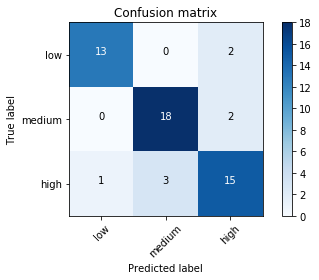

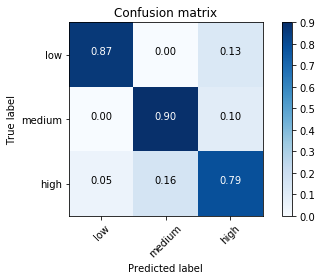

In [28]:
# display confusion matrix
cm = metrics.confusion_matrix(eX, pX)
# plot confusion matrix 
dt_utils.plot_cm(cm, bclass)
plt.show()

# normalized confusion matrix
dt_utils.plot_cm(cm, bclass, normalize=True)
plt.show()

The high birth rate class have (column) false positives and (row) false negatives.

{'max_features': 4, 'n_estimators': 150}
15


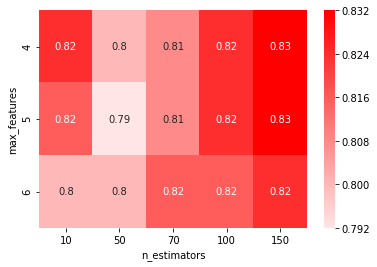

In [29]:
# estimate hyperparameter
params3 = {
            'n_estimators' :  [10, 50, 70, 100, 150],
            'max_features' : [4, 5, 6]
         }
score = 'accuracy'

# tuning hyperparameter
clfX = model_selection.GridSearchCV(ensemble.RandomForestClassifier(), params3, cv=5, scoring='%s' % score)
clfX.fit(train_dataX, train_targetX)
e2 = test_targetX
p2 = clfX.predict(test_dataX)
print(clfX.best_params_)

# Calculate the mean test score
means = clfX.cv_results_['mean_test_score']
print(len(means))

# display heatmap
labels = [k for k,v in params3.items()]
classes = [v for k,v in params3.items()]
dt_utils.heatmap(means.reshape(3, 5), classes=classes, labels=labels, palette="Red")

In [30]:
# display classification report 
report = metrics.classification_report(e2, p2, target_names=bclass)
print(report)
# accuracy score 
acc = metrics.accuracy_score(e2, p2)
print('Accuracy : {}'.format(acc))

scores = model_selection.cross_val_score(clfX, data_new, target, cv=5)
print('--------------------------------------------------')
print(scores)
print("CV Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

             precision    recall  f1-score   support

        low       1.00      0.87      0.93        15
     medium       0.89      0.85      0.87        20
       high       0.77      0.89      0.83        19

avg / total       0.88      0.87      0.87        54

Accuracy : 0.8703703703703703
--------------------------------------------------
[0.78947368 0.83333333 0.88571429 0.77142857 0.88571429]
CV Accuracy: 0.83 (+/- 0.09)
